Objective: 5420426 meters
Route for vehicle 0:
 0 ->  7 ->  16 ->  3 ->  8 ->  6 -> 0
Distance of the route: 19695m

Route for vehicle 1:
 0 ->  5 ->  1 ->  9 ->  2 ->  14 ->  15 ->  11 ->  13 ->  4 ->  12 -> 0
Distance of the route: 43287m

Route for vehicle 2:
 0 -> 0
Distance of the route: 0m

Route for vehicle 3:
 0 ->  10 -> 0
Distance of the route: 53044m

Maximum of the route distances: 53044m


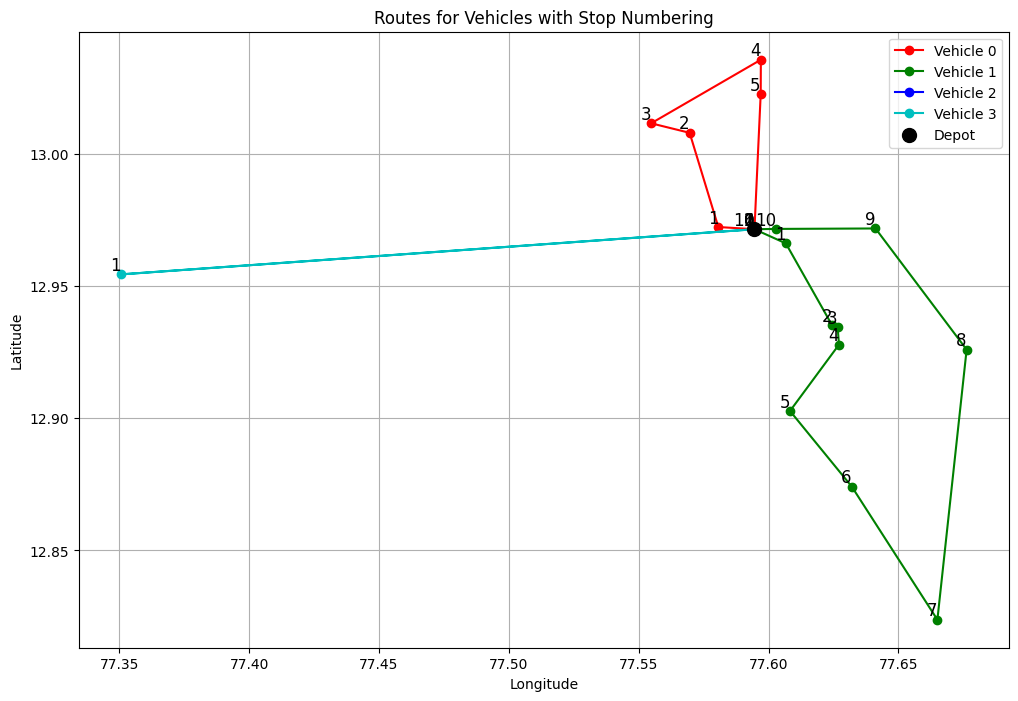

In [3]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Latitude and longitude coordinates of locations in Bangalore, India
    data["locations"] = [
        (12.9715987, 77.5945627),  # Bangalore City Center (Depot)
        (12.9351929, 77.6244807),  # Koramangala
        (12.9279232, 77.6271078),  # M.G. Road
        (13.0117002, 77.5547754),  # Yeshwanthpur
        (12.9718915, 77.6411545),  # Indiranagar
        (12.9662442, 77.606641),   # Lalbagh Botanical Garden
        (13.0227134, 77.5969603),  # Hebbal
        (12.972442, 77.580643),    # Vidhana Soudha
        (13.0357703, 77.5970225),  # Manyata Tech Park
        (12.9345334, 77.626579),   # Jayanagar
        (12.954517, 77.350736),    # Bannerghatta National Park
        (12.8237803, 77.6649865),  # Electronic City
        (12.9717201, 77.6027821),  # Cubbon Park
        (12.926031, 77.676246),    # Sarjapur
        (12.9028005, 77.6082448),  # HSR Layout
        (12.874145, 77.632046),    # Bommanahalli
        (13.0081, 77.5696)         # Mathikere
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0  # Start from Bangalore City Center
    return data

def compute_distance(location1, location2):
    """Computes the distance between two latitude/longitude coordinates."""
    return geodesic(location1, location2).meters

def print_solution(data, manager, routing, solution):
    """Prints solution on console and plot the routes."""
    print(f"Objective: {solution.ObjectiveValue()} meters")
    max_route_distance = 0
    all_routes = []

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route = []

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(data["locations"][node_index])
            plan_output += f" {node_index} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        node_index = manager.IndexToNode(index)
        route.append(data["locations"][node_index])
        plan_output += f"{node_index}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
        all_routes.append(route)

    print(f"Maximum of the route distances: {max_route_distance}m")
    
    # Plot the routes
    plot_routes(all_routes)

def plot_routes(routes):
    """Plots the routes on a map with numbering for each stop."""
    plt.figure(figsize=(12, 8))

    # Plot each route
    colors = ['r', 'g', 'b', 'c']  # Different colors for each vehicle
    for i, route in enumerate(routes):
        latitudes, longitudes = zip(*route)
        plt.plot(longitudes, latitudes, marker='o', color=colors[i % len(colors)], label=f'Vehicle {i}')

        # Add numbering for each stop in the route
        for step, (lat, long) in enumerate(route):
            plt.text(long, lat, str(step), fontsize=12, color='black', ha='right', va='bottom')

    # Highlight the depot
    depot_lat, depot_long = routes[0][0]
    plt.scatter([depot_long], [depot_lat], c='black', s=100, label='Depot', zorder=5)

    # Labeling and setting the limits for a better view
    plt.title('Routes for Vehicles with Stop Numbering')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)

    # Save plot to a file
    plt.savefig('routes_with_numbering.png')
    plt.show()


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(compute_distance(data["locations"][from_node], data["locations"][to_node]))

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance (20,000 km)
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and plot the result.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")

if __name__ == "__main__":
    main()


Objective: 10376437 meters
Route for vehicle 0:
 0 ->  12 ->  5 ->  1 ->  9 ->  2 ->  14 ->  15 ->  11 ->  13 ->  4 ->  6 ->  8 ->  16 ->  3 ->  10 ->  7 -> 0
Distance of the route: 102737m



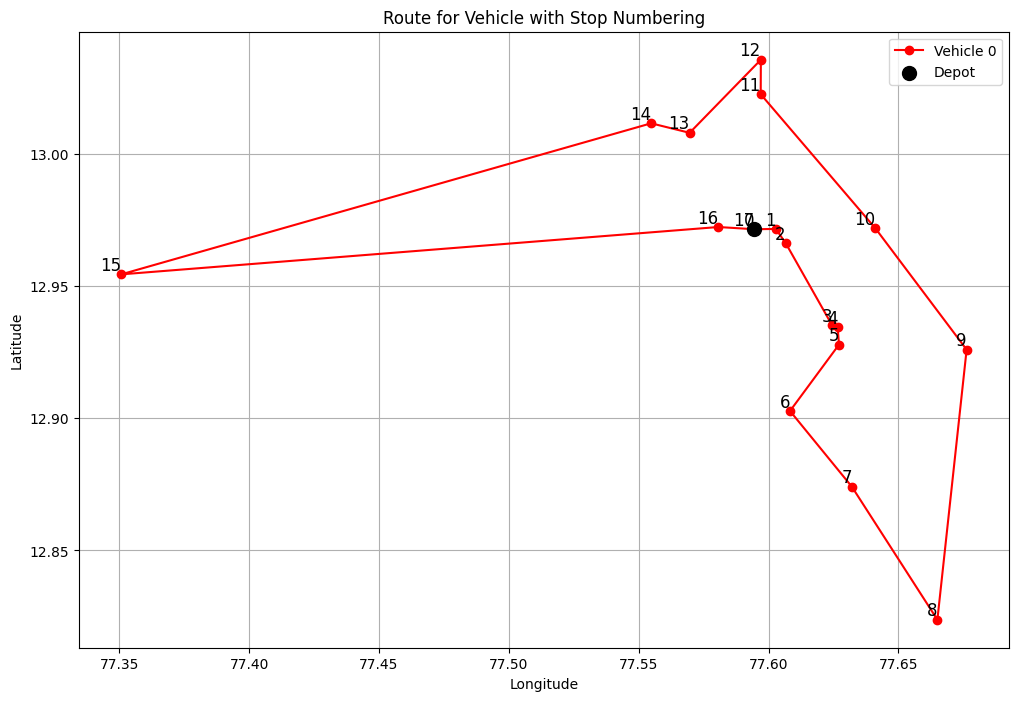

In [4]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Latitude and longitude coordinates of locations in Bangalore, India
    data["locations"] = [
        (12.9715987, 77.5945627),  # Bangalore City Center (Depot)
        (12.9351929, 77.6244807),  # Koramangala
        (12.9279232, 77.6271078),  # M.G. Road
        (13.0117002, 77.5547754),  # Yeshwanthpur
        (12.9718915, 77.6411545),  # Indiranagar
        (12.9662442, 77.606641),   # Lalbagh Botanical Garden
        (13.0227134, 77.5969603),  # Hebbal
        (12.972442, 77.580643),    # Vidhana Soudha
        (13.0357703, 77.5970225),  # Manyata Tech Park
        (12.9345334, 77.626579),   # Jayanagar
        (12.954517, 77.350736),    # Bannerghatta National Park
        (12.8237803, 77.6649865),  # Electronic City
        (12.9717201, 77.6027821),  # Cubbon Park
        (12.926031, 77.676246),    # Sarjapur
        (12.9028005, 77.6082448),  # HSR Layout
        (12.874145, 77.632046),    # Bommanahalli
        (13.0081, 77.5696)         # Mathikere
    ]
    data["num_vehicles"] = 1  # Use only 1 vehicle now
    data["depot"] = 0  # Start from Bangalore City Center
    return data

def compute_distance(location1, location2):
    """Computes the distance between two latitude/longitude coordinates."""
    return geodesic(location1, location2).meters

def print_solution(data, manager, routing, solution):
    """Prints solution on console and plot the routes."""
    print(f"Objective: {solution.ObjectiveValue()} meters")
    route_distance = 0
    route = []
    
    index = routing.Start(0)  # Only one vehicle (vehicle_id = 0)
    plan_output = "Route for vehicle 0:\n"

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(data["locations"][node_index])
        plan_output += f" {node_index} -> "
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    node_index = manager.IndexToNode(index)
    route.append(data["locations"][node_index])
    plan_output += f"{node_index}\n"
    plan_output += f"Distance of the route: {route_distance}m\n"
    print(plan_output)

    # Plot the route for the single vehicle
    plot_route(route)

def plot_route_with_arrows(route):
    """Plots the route with arrows indicating travel direction and stop numbering."""
    plt.figure(figsize=(10, 8))
    
    # Extract latitudes and longitudes
    latitudes, longitudes = zip(*route)

    # Plot route with arrows to show direction of travel
    for i in range(len(route) - 1):
        plt.arrow(longitudes[i], latitudes[i], 
                  longitudes[i + 1] - longitudes[i], 
                  latitudes[i + 1] - latitudes[i], 
                  head_width=0.0005, color='blue', length_includes_head=True)

    # Plot the stops (nodes) as red circles
    plt.scatter(longitudes, latitudes, marker='o', color='red', s=100, zorder=5)

    # Annotate each stop with its index in the route
    for i, (lat, long) in enumerate(route):
        plt.text(long, lat, str(i), fontsize=12, ha='right', va='bottom', color='black')

    # Highlight the depot (the first location in the route)
    depot_lat, depot_long = route[0]
    plt.scatter([depot_long], [depot_lat], c='green', s=150, label='Depot', zorder=6)

    # Add labels and grid
    plt.title('Travel Route with Arrows Indicating Direction')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Show the plot
    plt.show()

def print_solution(data, manager, routing, solution):
    """Prints solution on console and plot the routes."""
    print(f"Objective: {solution.ObjectiveValue()} meters")
    route_distance = 0
    route = []
    
    index = routing.Start(0)  # Only one vehicle (vehicle_id = 0)
    plan_output = "Route for vehicle 0:\n"

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(data["locations"][node_index])
        plan_output += f" {node_index} -> "
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    node_index = manager.IndexToNode(index)
    route.append(data["locations"][node_index])
    plan_output += f"{node_index}\n"
    plan_output += f"Distance of the route: {route_distance}m\n"
    print(plan_output)

    # Plot the route with arrows
    plot_route_with_arrows(route)

def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(compute_distance(data["locations"][from_node], data["locations"][to_node]))

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance (20,000 km)
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and plot the result.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")

if __name__ == "__main__":
    main()


Objective: 10537229 meters
Route for vehicle 0:
 0 ->  8 ->  10 ->  15 ->  1 ->  14 ->  5 ->  6 ->  2 ->  11 ->  4 ->  12 ->  3 ->  13 ->  7 ->  9 -> 0
Distance of the route: 104329m



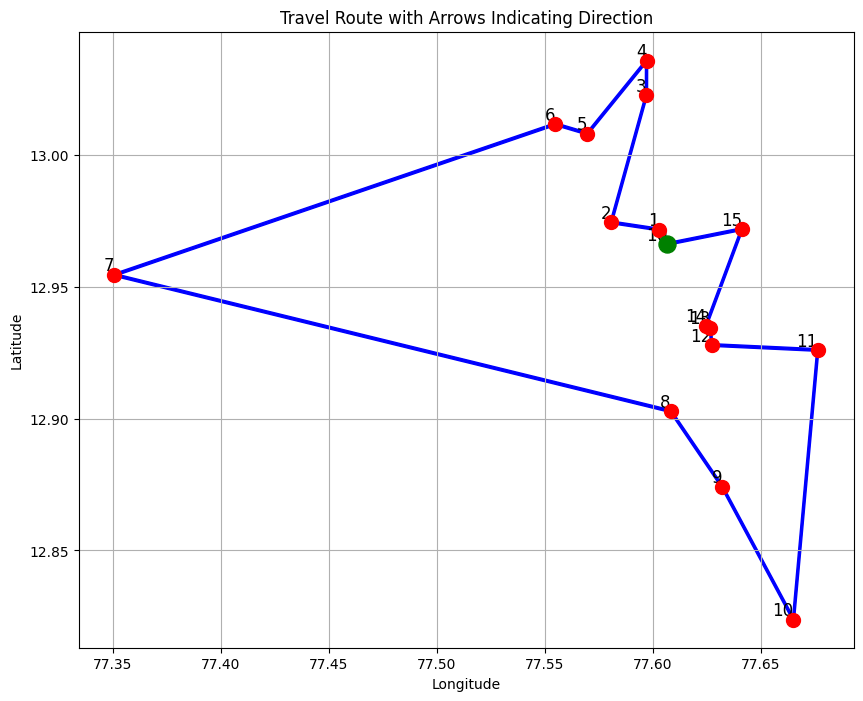

In [9]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Latitude and longitude coordinates of locations in Bangalore, India
    data["locations"] = [
        (12.9662442, 77.606641),  # Lalbagh Botanical Garden (Depot)
        (12.874145, 77.632046),  # Bommanahalli
        (13.0357703, 77.5970225),  # Manyata Tech Park
        (12.9028005, 77.6082448),  # HSR Layout
        (12.9279232, 77.6271078),  # M.G. Road
        (12.8237803, 77.6649865),  # Electronic City
        (13.0117002, 77.5547754),  # Yeshwanthpur
        (12.954517, 77.350736),  # Bannerghatta National Park
        (12.9351929, 77.6244807),  # Koramangala
        (12.9717201, 77.6027821),  # Cubbon Park
        (12.9718915, 77.6411545),  # Indiranagar
        (12.974442, 77.580643),  # Vidhana Soudha
        (12.926031, 77.676246),  # Sarjapur
        (12.9345334, 77.626579),  # Jayanagar
        (13.0081, 77.5696),  # Mathikere
        (13.0227134, 77.5969603)  # Hebbal
    ]
    data["num_vehicles"] = 1  # Use only 1 vehicle now
    data["depot"] = 0  # Start from Lalbagh Botanical Garden
    return data

def compute_distance(location1, location2):
    """Computes the distance between two latitude/longitude coordinates."""
    return geodesic(location1, location2).meters

def plot_route_with_arrows(route):
    """Plots the route with arrows indicating travel direction and stop numbering."""
    plt.figure(figsize=(10, 8))
    
    # Extract latitudes and longitudes
    latitudes, longitudes = zip(*route)

    # Plot route with arrows to show direction of travel
    for i in range(len(route) - 1):
        plt.arrow(longitudes[i], latitudes[i], 
                  longitudes[i + 1] - longitudes[i], 
                  latitudes[i + 1] - latitudes[i], 
                  head_width=0.0005, color='blue', length_includes_head=True)

    # Plot the stops (nodes) as red circles
    plt.scatter(longitudes, latitudes, marker='o', color='red', s=100, zorder=5)

    # Annotate each stop with its index in the route
    for i, (lat, long) in enumerate(route):
        plt.text(long, lat, str(i), fontsize=12, ha='right', va='bottom', color='black')

    # Highlight the depot (the first location in the route)
    depot_lat, depot_long = route[0]
    plt.scatter([depot_long], [depot_lat], c='green', s=150, label='Depot', zorder=6)

    # Add labels and grid
    plt.title('Travel Route with Arrows Indicating Direction')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Show the plot
    plt.show()

def print_solution(data, manager, routing, solution):
    """Prints solution on console and plot the routes."""
    print(f"Objective: {solution.ObjectiveValue()} meters")
    route_distance = 0
    route = []
    
    index = routing.Start(0)  # Only one vehicle (vehicle_id = 0)
    plan_output = "Route for vehicle 0:\n"

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(data["locations"][node_index])
        plan_output += f" {node_index} -> "
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    node_index = manager.IndexToNode(index)
    route.append(data["locations"][node_index])
    plan_output += f"{node_index}\n"
    plan_output += f"Distance of the route: {route_distance}m\n"
    print(plan_output)

    # Plot the route with arrows
    plot_route_with_arrows(route)

def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(compute_distance(data["locations"][from_node], data["locations"][to_node]))

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance (20,000 km)
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and plot the result.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")

if __name__ == "__main__":
    main()


In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    # Latitude and longitude coordinates of locations in Bangalore, India
    data["locations"] = [
        (12.9715987, 77.5945627),  # Bangalore City Center (Depot)
        (12.9351929, 77.6244807),  # Koramangala
        (12.9279232, 77.6271078),  # M.G. Road
        (13.0117002, 77.5547754),  # Yeshwanthpur
        (12.9718915, 77.6411545),  # Indiranagar
        (12.9662442, 77.606641),   # Lalbagh Botanical Garden
        (13.0227134, 77.5969603),  # Hebbal
        (12.972442, 77.580643),    # Vidhana Soudha
        (13.0357703, 77.5970225),  # Manyata Tech Park
        (12.9345334, 77.626579),   # Jayanagar
        (12.954517, 77.350736),    # Bannerghatta National Park
        (12.8237803, 77.6649865),  # Electronic City
        (12.9717201, 77.6027821),  # Cubbon Park
        (12.926031, 77.676246),    # Sarjapur
        (12.9028005, 77.6082448),  # HSR Layout
        (12.874145, 77.632046),    # Bommanahalli
        (13.0081, 77.5696)         # Mathikere
    ]
    data["num_vehicles"] = 1  # Use only 1 vehicle now
    data["depot"] = 0  # Start from Bangalore City Center
    return data

def compute_distance(location1, location2):
    """Computes the distance between two latitude/longitude coordinates."""
    return geodesic(location1, location2).meters

def plot_route_with_arrows(route):
    """Plots the route with arrows indicating travel direction and stop numbering."""
    plt.figure(figsize=(10, 8))
    
    # Extract latitudes and longitudes
    latitudes, longitudes = zip(*route)

    # Plot route with arrows to show direction of travel
    for i in range(len(route) - 1):
        plt.arrow(longitudes[i], latitudes[i], 
                  longitudes[i + 1] - longitudes[i], 
                  latitudes[i + 1] - latitudes[i], 
                  head_width=0.0005, color='blue', length_includes_head=True)

    # Plot the stops (nodes) as red circles
    plt.scatter(longitudes, latitudes, marker='o', color='red', s=100, zorder=5)

    # Annotate each stop with its index in the route
    for i, (lat, long) in enumerate(route):
        plt.text(long, lat, str(i), fontsize=12, ha='right', va='bottom', color='black')

    # Highlight the depot (the first location in the route)
    depot_lat, depot_long = route[0]
    plt.scatter([depot_long], [depot_lat], c='green', s=150, label='Depot', zorder=6)

    # Add labels and grid
    plt.title('Travel Route with Arrows Indicating Direction')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Show the plot
    plt.show()

def print_solution(data, manager, routing, solution):
    """Prints solution on console and plot the routes."""
    print(f"Objective: {solution.ObjectiveValue()} meters")
    route_distance = 0
    route = []
    
    index = routing.Start(0)  # Only one vehicle (vehicle_id = 0)
    plan_output = "Route for vehicle 0:\n"

    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(data["locations"][node_index])
        plan_output += f" {node_index} -> "
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    
    node_index = manager.IndexToNode(index)
    route.append(data["locations"][node_index])
    plan_output += f"{node_index}\n"
    plan_output += f"Distance of the route: {route_distance}m\n"
    print(plan_output)

    # Plot the route with arrows
    plot_route_with_arrows(route)

def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(compute_distance(data["locations"][from_node], data["locations"][to_node]))

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance (20,000 km)
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console and plot the result.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")

if __name__ == "__main__":
    main()